# Importing necessary libraries

In [1]:
import numpy as np                                # For numerical operations and handling arrays
import pandas as pd                               # For data manipulation and analysis
import seaborn as sns                             # For statistical data visualization (e.g., heatmaps)
import matplotlib.pyplot as plt                   # For visualizing data
from sklearn.preprocessing import MinMaxScaler    # For scaling the data (Min-Max)
from sklearn.preprocessing import StandardScaler  # For scaling the data (Standardization)
from sklearn.cluster import KMeans                # For K-Means clustering
from sklearn.cluster import DBSCAN                # For DBSCAN clustering
from sklearn.metrics import silhouette_score      # For evaluating clustering performance
from sklearn.manifold import TSNE                 # For dimensionality reduction (t-SNE)
from sklearn.decomposition import PCA
import os                                         # For Traversing through directories to find and access files (useful for Kaggle Kernels)
import warnings


# Ignore all warnings
warnings.filterwarnings('ignore')

# Finding path of csv or xlsx file

In [2]:
# Loop through all files in the input directory and get their paths
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_Path = os.path.join(dirname, filename)  # Construct and Storing full path of the Excel file

# Reading and Showing Data Head

In [3]:
# Reading the Excel file
customer_data = pd.read_excel(file_Path)              
# Displaying the data
customer_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Calculate RFM Metrics
We calculate the following for each customer:

1. **`Recency`**: How recently the customer made a purchase.

2. **`Frequency`**: How often the customer makes a purchase.

3. **`Monetary`**: How much the customer spends.

In [4]:
# Creating Total_Price column
customer_data['Total_Price'] = customer_data['Quantity'] * customer_data['UnitPrice']

# Reference date for recency calculation
reference_date = customer_data['InvoiceDate'].max()

# Creating new DataFrame, grouping by CustomerID and calculating RFM metrics
customer_data_rfm = customer_data.groupby('CustomerID').agg({
    # Calculate Recency as the number of days since the most recent purchase for each customer
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency (days since last purchase)

    # Count the number of invoices for each customer to calculate Frequency
    'InvoiceNo': 'count',                                      # Frequency (number of transactions)

    # Calculate the total spending of each customer by summing the 'Total_Price'
    'Total_Price': 'sum'                                       # Monetary (total money spent)
})

# Rename columns for clarity
customer_data_rfm = customer_data_rfm.rename(columns={
    'InvoiceDate': 'Recency',      # Renaming InvoiceDate column as Recency
    'InvoiceNo': 'Frequency',      # Renaming InvoiceNo column as Frequency
    'Total_Price': 'Monetary'      # Renaming Total_Price column as Monetary
}).reset_index()

# Saving preprocessed dataset
customer_data_rfm.to_csv('customer_data_rfm.csv', index=False)

# Display the first few rows of the RFM DataFrame
customer_data_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


# Normalize the Data
**To ensure that the clustering algorithm does not get biased by different scales of data, we normalize the RFM features.**

In [5]:
# Normalizing RFM data using Min-Max Scaling
scaler = MinMaxScaler()
customer_data_scaled = scaler.fit_transform(customer_data_rfm[['Recency', 'Frequency', 'Monetary']])

# Createreating a new DataFrame for the scaled features
customer_data_normalized = pd.DataFrame(customer_data_scaled, columns= ['Recency','Frequency','Monetary'])

# Combine the normalized features with the CustomerID
customer_data_normalized = pd.concat([customer_data_rfm[['CustomerID']].reset_index(drop=True), customer_data_normalized], axis=1)

# Saving Normalized dataset
customer_data_normalized.to_csv('customer_data_normalized.csv', index=False)  # After scaling

# Displaying the RFM DataFrame
print("RFM DataFrame before scaling the data:")
print(customer_data_rfm.head())

# Displaying the normalized RFM DataFrame
print("\nNormalized RFM DataFrame after scaling the data:")
print(customer_data_normalized.head())

RFM DataFrame before scaling the data:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          2      0.00
1     12347.0        1        182   4310.00
2     12348.0       74         31   1797.24
3     12349.0       18         73   1757.55
4     12350.0      309         17    334.40

Normalized RFM DataFrame after scaling the data:
   CustomerID   Recency  Frequency  Monetary
0     12346.0  0.871314   0.000125  0.015109
1     12347.0  0.002681   0.022676  0.030297
2     12348.0  0.198391   0.003758  0.021442
3     12349.0  0.048257   0.009020  0.021303
4     12350.0  0.828418   0.002005  0.016288


# **Applying Clustering Algorithms**
**K-Means Clustering**

First, we apply **K-Means Clustering** to segment customers based on the RFM metrics.

Determine the Optimal Number of Clusters using the **`Elbow Method`** & **`Silhouette Score`**.

In [6]:
# Applying K-Means with the optimal number of clusters
optimal_k = 8  # Example based on analysis (adjust based on your results)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data_rfm['K_Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Inspect clusters
print(customer_data_rfm.groupby('K_Cluster').mean())

             CustomerID     Recency    Frequency       Monetary
K_Cluster                                                      
0          15182.785609   73.330396    54.748899    1006.313131
1          15287.769679  260.326531    23.653061     476.241195
2          15273.672775  129.602094    45.219895     761.881859
3          15314.654804  338.419929    23.327402     322.855160
4          15485.670423  191.312676    33.425352     559.862707
5          15239.415557    9.522074   153.450596    2982.809488
6          15423.920314   36.668911    81.499439    1335.441067
7          15189.666667    4.000000  2845.583333  118713.023333


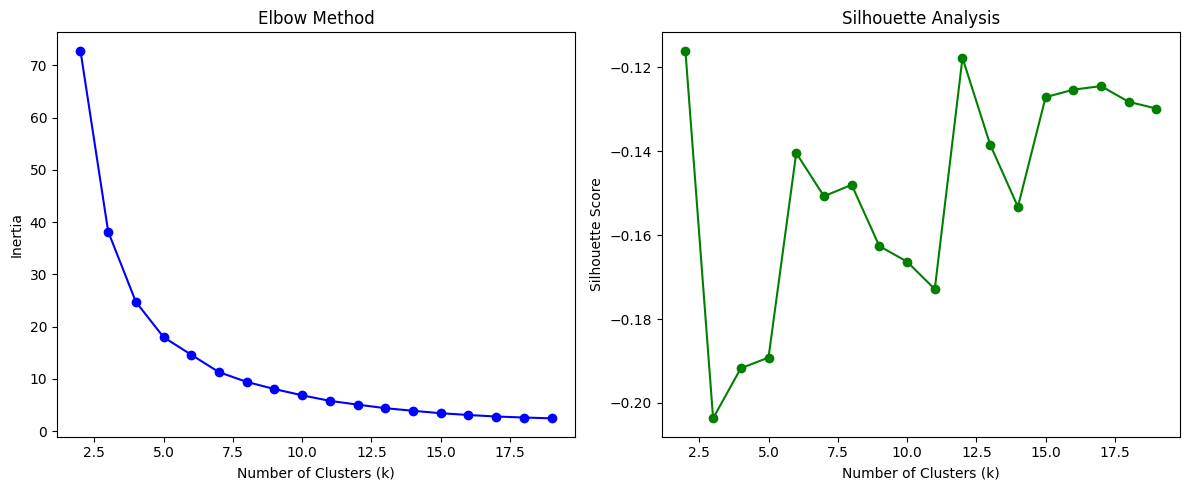

In [7]:
from sklearn.metrics import silhouette_score

# Elbow Method
inertia = []
silhouette_scores = []
K = range(2, 20)

for n in K:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(customer_data_rfm, kmeans.labels_))

# Plot Elbow Method
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

In [8]:
# Applying DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_data_rfm['DB_Cluster'] = dbscan.fit_predict(customer_data_scaled)

# Inspect clusters
print(customer_data_rfm.groupby('DB_Cluster').mean())

              CustomerID    Recency  Frequency     Monetary  K_Cluster
DB_Cluster                                                            
0           15299.677722  91.047118  93.053294  1898.459701   3.644785


In [9]:
# Saving clusters output dataset
customer_data_rfm.to_csv('customer_data_rfm.csv', index=False)

# Sample output of clusters
print("DBSCAN Clustered Data (First 10 rows):")
print(customer_data_rfm.head(45))

DBSCAN Clustered Data (First 10 rows):
    CustomerID  Recency  Frequency  Monetary  K_Cluster  DB_Cluster
0      12346.0      325          2      0.00          3           0
1      12347.0        1        182   4310.00          5           0
2      12348.0       74         31   1797.24          0           0
3      12349.0       18         73   1757.55          5           0
4      12350.0      309         17    334.40          3           0
5      12352.0       35         95   1545.41          6           0
6      12353.0      203          4     89.00          4           0
7      12354.0      231         58   1079.40          1           0
8      12355.0      213         13    459.40          4           0
9      12356.0       22         59   2811.43          5           0
10     12357.0       32        131   6207.67          6           0
11     12358.0        1         19   1168.06          5           0
12     12359.0        7        254   6245.53          5           0
13     12

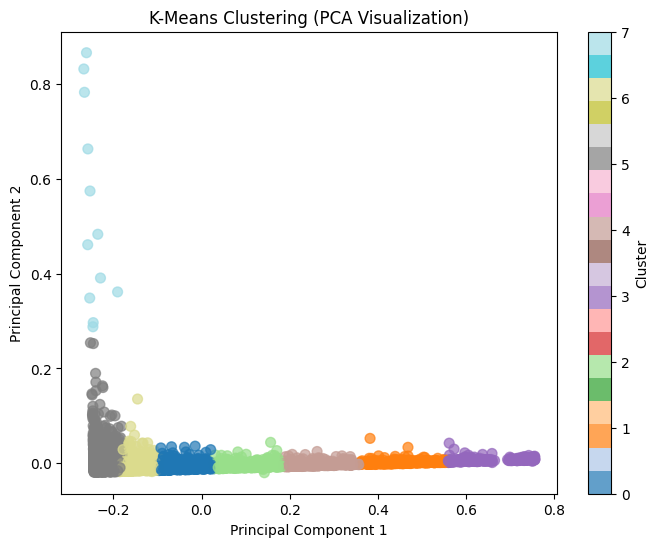

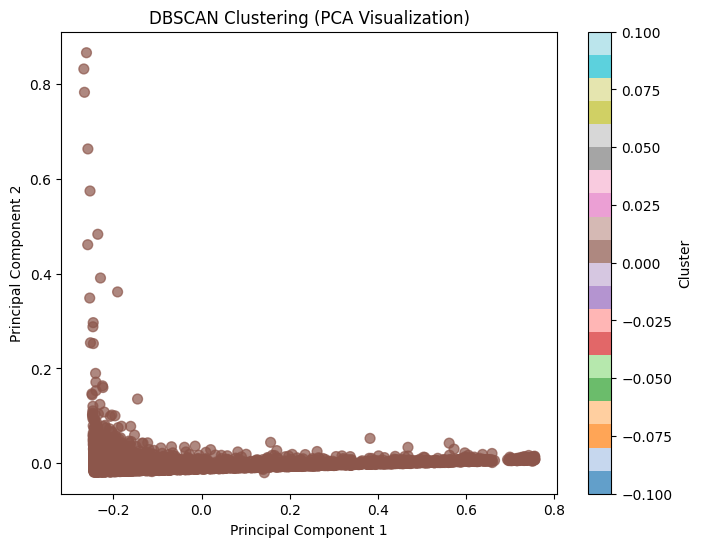

In [10]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(customer_data_scaled)
map = "tab20"

# Plot K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_data_rfm['K_Cluster'], cmap = map, s=50, alpha=0.7)
plt.title('K-Means Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Plot DBSCAN Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_data_rfm['DB_Cluster'], cmap = map, s=50, alpha=0.7)
plt.title('DBSCAN Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


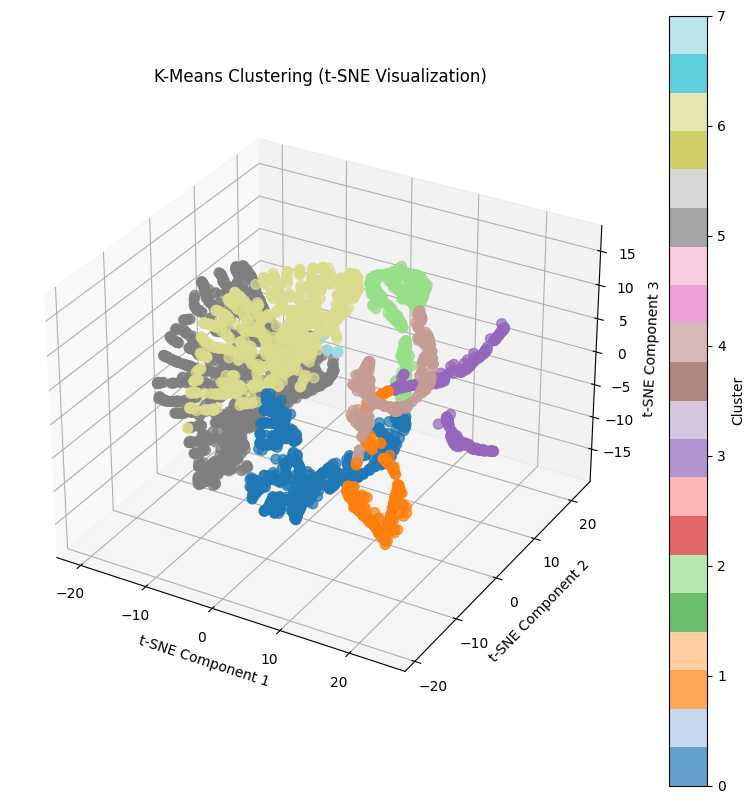

In [11]:
# Apply t-SNE for 3D visualization
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(customer_data_scaled)

# 3D Scatter Plot (K-Means)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=customer_data_rfm['K_Cluster'], cmap = map, s=50, alpha=0.7)
ax.set_title('K-Means Clustering (t-SNE Visualization)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.colorbar(scatter, label='Cluster')
plt.show()


| **Cluster** | **Recency** | **Frequency** | **Monetary$**      | **Customer Categories** | **Marketing Strategy** |
|-------------|-------------|---------------|--------------------|--------------------------|--------------------------|
| 0           | 73 Days     | 54.75         | ≈ 1,006            | Loyal Customers          | **Loyalty Programs:** Offer exclusive rewards or discounts for repeat purchases to keep them engaged. Personalize content with VIP offers or special birthday/anniversary deals.
| 1           | 260 Days    | 23.65         | ≈ 476              | Dormant Customers        | **Re-engagement Campaigns:** Send personalized reactivation emails or SMS with special offers. Offer discounts or promotions to reignite interest and bring them back into the funnel.
| 2           | 129 Days    | 45.22         | ≈ 761              | Moderately Engaged       | **Product Recommendations:** Send tailored product recommendations based on previous behavior. Encourage them to increase purchase frequency with time-sensitive offers.
| 3           | 338 Days    | 23.33         | ≈ 322              | Very Inactive Customer   | **Targeted Promotions:** Send win-back campaigns with deep discounts or limited-time offers to attract attention. Consider a survey or feedback request to understand their inactivity.
| 4           | 191 Days    | 33.43         | ≈ 559              | Occasional Shoppers      | **Personalized Offers:** Send tailored offers based on past shopping habits, encouraging them to shop more frequently. Highlight new arrivals or seasonal promotions.
| 5           | 9 Days      | 153.45        | ≈ 2,982            | High Activity Customers  | **Exclusive VIP Access:** Offer sneak peeks or early access to new products or services. Provide special offers like bundle deals or loyalty bonuses to maintain high engagement.
| 6           | 36 Days     | 81.50         | ≈ 1,335            | Frequent Shoppers        | **Loyalty and Upselling:** Reward frequent shopping with loyalty points, and upsell or cross-sell complementary products. Encourage repeat visits through personalized recommendations.
| 7           | 4 Days      | 2,845.58      | ≈ 118,713          | Top Spenders             | **High-Touch Concierge Service:** Provide personalized concierge services and exclusive, high-value offers. Reward with customized gifts, VIP events, or loyalty programs for continued spending.


\infty - 1
